In [1]:
using Revise

In [2]:
using PyCall, PyPlot, Statistics, JuMP
mpl = pyimport("matplotlib");
mpl.rcParams["lines.linewidth"] = 2;

In [3]:
using ClimateMARGO
using ClimateMARGO.Models
using ClimateMARGO.Diagnostics
using ClimateMARGO.Optimization
using ClimateMARGO.Plotting
using ClimateMARGO.PolicyResponse

In [4]:
include("suboptimal_policy.jl");

# A policy process for responding to suboptimal climate outcomes

In [5]:
append_model!(model_list, model) = append!(model_list, [deepcopy(model)]);

In [6]:
base_model = deepcopy(ClimateModel(ClimateMARGO.IO.included_configurations["default"]));

base_model.economics.ρ = 0.02
base_model.economics.mitigate_init = 0.
delay_deployment=Dict(
    "mitigate"=>0,
    "remove"=>0,
    "geoeng"=>0,
    "adapt"=>0
);

max_deployment = Dict("mitigate"=>1., "remove"=>1., "geoeng"=>0., "adapt"=>0.);

## 1. Under-ambitious case

In [7]:
model = deepcopy(base_model)

temp_goal_list = [];
model_list = [];
hypo_model_list = [];

optimal = deepcopy(model)
optimize_controls!(optimal, max_deployment=max_deployment);

append_model!(model_list, model);
append_model!(hypo_model_list, model);


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Solve_Succeeded


In [8]:
function binary_search!(model, temp_goal; N=10)
    ΔT = 1.
    for i in 1:N
        temp_goal += ΔT
        m = optimize_controls!(model, temp_goal = temp_goal, max_deployment=max_deployment, print_raw_status=false)
        if (((raw_status(m) == "Solve_Succeeded") & (ΔT >= 0.)) | ((raw_status(m) != "Solve_Succeeded") & (ΔT <= 0.)))
            ΔT *= -0.5;
        else
            ΔT *= 0.5
        end
    end
    return temp_goal
end;

In [9]:
Δt = 10.
suboptimality = -0.5

temp_goal_og = 1.5

for i in 1:10
    println("Evaluating policy in ", model.domain.present_year)
    temp_goal = temp_goal_og
    m = optimize_controls!(model, temp_goal = temp_goal, max_deployment=max_deployment);
    if raw_status(m) != "Solve_Succeeded"
        temp_goal = binary_search!(model, temp_goal)
    end
    if temp_goal >= temp_goal_og
        print("Increased temperature goal to ", round(temp_goal, digits=3), "\n")
    end
    append_model!(hypo_model_list, model);
    suboptimal_step_forward!(model, model_list[end], Δt, 1+suboptimality);
    append_model!(model_list, model);
    append!(temp_goal_list, temp_goal);
end

Evaluating policy in 2020.0
Solve_Succeeded
Increased temperature goal to 1.5
Evaluating policy in 2030.0
Infeasible_Problem_Detected
Increased temperature goal to 1.596
Evaluating policy in 2040.0
Infeasible_Problem_Detected
Increased temperature goal to 1.658
Evaluating policy in 2050.0
Infeasible_Problem_Detected
Increased temperature goal to 1.682
Evaluating policy in 2060.0
Infeasible_Problem_Detected
Increased temperature goal to 1.701
Evaluating policy in 2070.0
Infeasible_Problem_Detected
Increased temperature goal to 1.713
Evaluating policy in 2080.0
Infeasible_Problem_Detected
Increased temperature goal to 1.721
Evaluating policy in 2090.0
Infeasible_Problem_Detected
Increased temperature goal to 1.725
Evaluating policy in 2100.0
Infeasible_Problem_Detected
Increased temperature goal to 1.729
Evaluating policy in 2110.0
Infeasible_Problem_Detected
Increased temperature goal to 1.729


In [11]:
suboptimalities = 0.: -0.01: -1.0
maxTs = zeros(size(suboptimalities))
solve_succeeded = zeros(size(suboptimalities))

Nt = 10
for (j, suboptimality) in enumerate(suboptimalities)
    print(j,"/",size(suboptimalities,1),", ")
    model = deepcopy(base_model)
    for i in 1:Nt
        temp_goal = temp_goal_og
        model_prev = deepcopy(model)
        m = optimize_controls!(model, temp_goal = temp_goal, max_deployment=max_deployment, print_raw_status=false);
        if raw_status(m) != "Solve_Succeeded"
            temp_goal = binary_search!(model, temp_goal, N=18)
        end
        suboptimal_step_forward!(model, model_prev, Δt, 1. +suboptimality);
    end
    maxTs[j] = maximum(T(model, M=true, R=true));
end

1/101, 2/101, 3/101, 4/101, 5/101, 6/101, 7/101, 8/101, 9/101, 10/101, 11/101, 12/101, 13/101, 14/101, 15/101, 16/101, 17/101, 18/101, 19/101, 20/101, 21/101, 22/101, 23/101, 24/101, 25/101, 26/101, 27/101, 28/101, 29/101, 30/101, 31/101, 32/101, 33/101, 34/101, 35/101, 36/101, 37/101, 38/101, 39/101, 40/101, 41/101, 42/101, 43/101, 44/101, 45/101, 46/101, 47/101, 48/101, 49/101, 50/101, 51/101, 52/101, 53/101, 54/101, 55/101, 56/101, 57/101, 58/101, 59/101, 60/101, 61/101, 62/101, 63/101, 64/101, 65/101, 66/101, 67/101, 68/101, 69/101, 70/101, 71/101, 72/101, 73/101, 74/101, 75/101, 76/101, 77/101, 78/101, 79/101, 80/101, 81/101, 82/101, 83/101, 84/101, 85/101, 86/101, 87/101, 88/101, 89/101, 90/101, 91/101, 92/101, 93/101, 94/101, 95/101, 96/101, 97/101, 98/101, 99/101, 100/101, 101/101, 

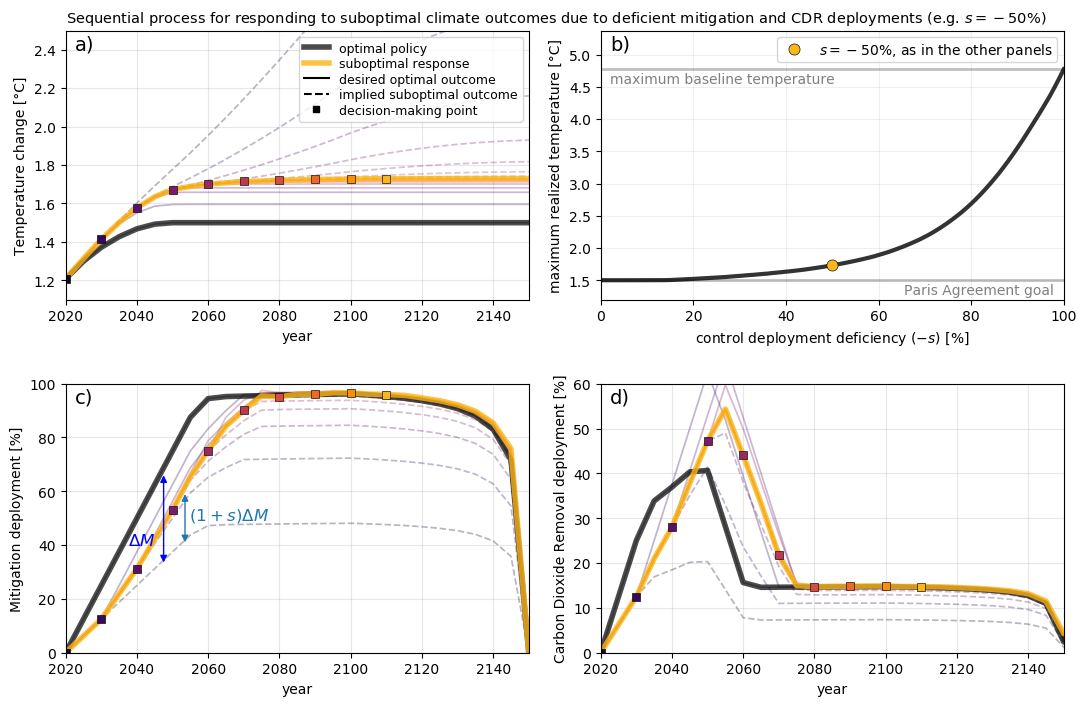

In [67]:
N = length(model_list)

xt = 2020:20:2150
xtn = convert(Array{Any}, copy(xt))
xtn[((xtn.-2000).%40).==0] .= nothing

arrowprops=Dict(
    "arrowstyle"=>"<|-|>",
    "fc"=>"C0", "ec"=>"C0"
)

arrowprops_b=Dict(
    "arrowstyle"=>"<|-|>",
    "fc"=>"b", "ec"=>"b"
)

alpha_step = 0.3
alpha_thick = 0.7
lw_thick = 4
cmap = get_cmap("inferno");

figure(figsize=(11,7))

##
ax = subplot(2,2,1)
grid(true, alpha=0.3)
for (i, m) in enumerate(model_list[2:end])
    if i==length(model_list[2:end]); lw=1.5; else; lw=1.25; end
    plot(t(m), T(m, M=true, R=true, G=true, A=true), "--", color=cmap(i/(N+1)), lw=lw, alpha=alpha_step)
end

for (i, m) in enumerate(hypo_model_list[2:end])
    if i==length(hypo_model_list[2:end]); lw=1.5; else; lw=1.25; end
    plot(t(m), T(m, M=true, R=true, G=true, A=true), "-", color=cmap(i/(N+1)), lw=lw, alpha=alpha_step)
end
plot(t(optimal), T(optimal, M=true, R=true, G=true, A=true), "k", lw=lw_thick, alpha=alpha_thick, label="optimal policy")
m = model_list[end]
plot(t(m), T(m, M=true, R=true, G=true, A=true), lw=lw_thick, alpha=alpha_thick+0.1, color=cmap((N-1)/(N+1)), label="suboptimal response")
for (i, m) in enumerate(hypo_model_list[2:end])
    idx = (t(m) .== m.domain.present_year)
    plot(t(m)[idx], T(m, M=true, R=true, G=true, A=true)[idx], color=cmap(i/(N+1)), marker="s", markersize=5.5, markeredgecolor="k", markeredgewidth=0.45)
end
ylim([optimal.physics.T0, 2.5])
xlim([2020, 2150])
xlabel("year")
xticks(xt, xt)
plot([],[], "k-", label="desired optimal outcome")
plot([],[], "k--", label="implied suboptimal outcome")
plot([],[], "ks", label="decision-making point", markersize=5)
legend(loc="upper right", labelspacing = 0.2, fontsize=9);
annotate("a)", xy=(0.02, 0.93), xycoords="axes fraction", fontsize=14)
ylabel("Temperature change [°C]")

##
subplot(2,2,2)
grid(true, alpha=0.2)
axhline(temp_goal_og, color="grey", alpha=0.5, lw=2)
axhline(maximum(T(base_model)), color="grey", alpha=0.5, lw=2)
plot(-suboptimalities*100, maxTs, color="k", lw=3., alpha=0.8)
plot(-suboptimality*100, maximum(T(model_list[end], M=true, R=true)), "o", color=cmap((N-1)/(N+1)), markersize=8,
    label=L"$s = -50\% $, as in the other panels", markeredgecolor="k", markeredgewidth=0.45
)
xlim(0, 100)
ylim([temp_goal_og-0.3, maximum(T(base_model))+0.6])
xlabel(L"control deployment deficiency ($-s$) [%]")
ylabel("maximum realized temperature [°C]")
annotate(s="maximum baseline temperature", xy=(2, maximum(T(base_model))-0.21), color="grey")
annotate(s="Paris Agreement goal", xy=(65.5, temp_goal_og-0.21), color="grey")
legend(loc="upper right", borderpad=0.25)
annotate("b)", xy=(0.02, 0.93), xycoords="axes fraction", fontsize=14)

## 
subplot(2,2,3)
grid(true, alpha=0.3)
for (i, m) in enumerate(model_list[2:end])
    if i==length(model_list[2:end]); lw=1.5; else; lw=1.25; end
    plot(t(m), m.controls.mitigate, "--", color=cmap(i/(N+1)), lw=lw, alpha=alpha_step)
end
for (i, m) in enumerate(hypo_model_list[2:end])
    if i==length(model_list[2:end]); lw=1.5; else; lw=1.25; end
    plot(t(m), m.controls.mitigate, "-", color=cmap(i/(N+1)), lw=lw, alpha=alpha_step)
end
plot(t(optimal), optimal.controls.mitigate, "k-", lw=lw_thick, alpha=alpha_thick)
m = model_list[end]
plot(t(m), m.controls.mitigate, lw=lw_thick, alpha=alpha_thick+0.1, color=cmap((N-1)/(N+1)))
for (i, m) in enumerate(hypo_model_list[2:end])
    idx = (t(m) .== m.domain.present_year)
    plot(t(m)[idx], m.controls.mitigate[idx], color=cmap(i/(N+1)), marker="s", markersize=5.5, markeredgecolor="k", markeredgewidth=0.45)
end
xlim([2020, 2150])
xlabel("year")
xticks(xt, xt)
yt = 0.:0.2:1.
yticks(yt, Int.(yt*100))
ylim(0, 1)
ylabel("Mitigation deployment [%]")
annotate("c)", xy=(0.02, 0.93), xycoords="axes fraction", fontsize=14)

annotate("", (2047.5, 0.325), xytext=(2047.5, 0.67), arrowprops=arrowprops_b)
annotate(L"$\Delta M$", (2037.5, 0.40), fontsize=12, color="b");

annotate("", (2053.5, 0.40), xytext=(2053.5, 0.60), arrowprops=arrowprops)
annotate(L"$(1+s)\Delta M$", (2054.5, 0.495), fontsize=12, color="C0");

subplot(2,2,4)
grid(true, alpha=0.3)
for (i, m) in enumerate(model_list[2:end])
    if i==length(model_list[2:end]); lw=1.5; else; lw=1.25; end
    plot(t(m), m.controls.remove, "--", color=cmap(i/(N+1)), lw=lw, alpha=alpha_step)
end
for (i, m) in enumerate(hypo_model_list[2:end])
    if i==length(model_list[2:end]); lw=1.5; else; lw=1.25; end
    plot(t(m), m.controls.remove, "-", color=cmap(i/(N+1)), lw=lw, alpha=alpha_step)
end
plot(t(optimal), optimal.controls.remove, "k-", lw=lw_thick, alpha=alpha_thick)
m = model_list[end]
plot(t(m), m.controls.remove, lw=lw_thick, alpha=alpha_thick+0.1, color=cmap((N-1)/(N+1)))
for (i, m) in enumerate(hypo_model_list[2:end])
    idx = (t(m) .== m.domain.present_year)
    plot(t(m)[idx], m.controls.remove[idx], color=cmap(i/(N+1)), marker="s", markersize=5.5, markeredgecolor="k", markeredgewidth=0.45)
end
xlim([2020, 2150])
xlabel("year")
xticks(xt, xt)
yt = 0.:0.1:0.6
yticks(yt, Int.(yt*100))
ylim(0, 0.6)
ylabel("Carbon Dioxide Removal deployment [%]")
xticks()
annotate("d)", xy=(0.02, 0.93), xycoords="axes fraction", fontsize=14)
tight_layout(w_pad=1.8)

suboptimal_percentage = abs(Int(round(suboptimality*100)))
ax.set_title(
    string(L"Sequential process for responding to suboptimal climate outcomes due to deficient mitigation and CDR deployments (e.g. $s=-$","$(suboptimal_percentage)%)"),
    loc="left", y=1.045, fontsize=10.5
)

savefig("figures/suboptimal_under-ambitious.png", dpi=200., bbox_inches="tight")